# 01. Data preparation

1. Load raw dataframes
2. *Normalize per team*
3. *Cluster team data*
4. Combine with FM data

**Normalize per team:**

We will normalize stats per each team. The point is that a defensive player of a stronger team might have more attacking stats than an attacking player of a weaker team just because of overall possession and tactics. Team information would be passed as a cluster type, but for the purpose of stats analysis it is best to have information about a player from within the team, how important their contribution is for the team

**Cluster team data:**

Mean statistics grouped by team would be used to cluster teams. The cluster will then be used as a feature to evaluate players

In [1]:
# change wd to repo home
import os
if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
from modules.fm_functions import *

## Combine all FBRef data into one dataframe

In [3]:
import pandas as pd

In [4]:
# load FBRef data in separate dfs
fbref_dfs = {filename : pd.read_csv(f'data/FBRef_split/{filename}', index_col=0)
             for filename in os.listdir('data/FBRef_split')}

In [5]:
# combine FBRef dfs by type first
table_types = ['defense', 'gca', 'keepersadv', 'keepers', 'misc', 'passingtypes',
               'passing', 'playingtime', 'possession', 'shooting', 'stats']

fbref_dfs_types = {}

for t in table_types:
    fbref_dfs_types[t] = {}
    for k in fbref_dfs.keys():
        if k.split('_')[1] == t:
            fbref_dfs_types[t][k.split('_')[0]] = fbref_dfs[k]
    fbref_dfs_types[t] = pd.concat(fbref_dfs_types[t], axis=0, ignore_index=True).set_index(['_Player', '_Squad', '_Born'])

In [6]:
# combine FBRef dfs into one
fbref_combined_df = pd.concat(fbref_dfs_types, axis=1).reset_index()
fbref_combined_df.columns = fbref_combined_df.columns.map(lambda x: '_'.join(map(str, x)))

In [7]:
# store a complete FBRef file
fbref_combined_df.to_csv('data/FBRef_combined.csv')

## Normalize each column selection by team

In [8]:
from sklearn.preprocessing import MinMaxScaler

Drop players with fewer than 500 minutes

In [9]:
fbref_combined_filtered_df = fbref_combined_df[fbref_combined_df['playingtime_PlayingTime_Min']>=500]

In [10]:
# function to apply Min-Max scaling based on selected group and per-90 minutes stats
def minmax_scaling(group):
    scaler = MinMaxScaler()
    # Divide each column by 'playingtime_PlayingTime_Min' except for 'playingtime_PlayingTime_Min' itself
    for column in all_stats_columns:
        if column != 'playingtime_PlayingTime_Min' and column in group.columns:
            group[column] = group[column] / group['playingtime_PlayingTime_Min']
    # Apply Min-Max scaling
    group[all_stats_columns] = scaler.fit_transform(group[all_stats_columns])
    return group

In [11]:
fbref_normalized_df = fbref_combined_filtered_df.groupby('_Squad_', as_index=False).apply(minmax_scaling)

## Cluster teams

In [12]:
fbref_teams_df = fbref_combined_filtered_df.groupby('_Squad_')[all_stats_columns].mean()

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [14]:
team_scaler = StandardScaler()
fbref_teams_scaled = team_scaler.fit_transform(fbref_teams_df.values)

In [15]:
import seaborn as sns

n_clusters = {}
for k in range(1,11):
    team_clusters_kmeans = KMeans(n_clusters=k)
    team_clusters_kmeans.fit(fbref_teams_scaled)
    n_clusters[k] = team_clusters_kmeans.inertia_

c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a

<Axes: >

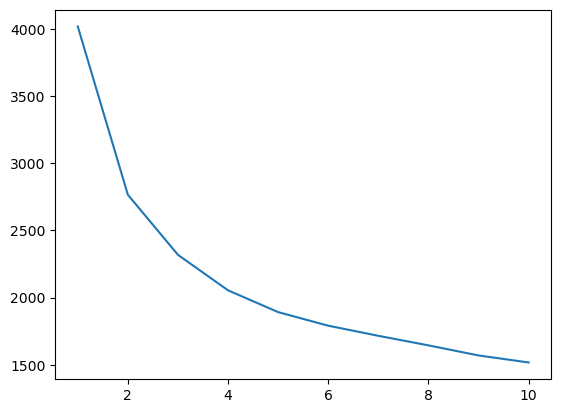

In [16]:
sns.lineplot(n_clusters)

In [17]:
team_clusters_kmeans = KMeans(n_clusters=4)

team_clusters = team_clusters_kmeans.fit_predict(fbref_teams_scaled)

fbref_teams_df['cluster'] = team_clusters

c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [18]:
fbref_normalized_df['team_cluster'] = fbref_teams_df.loc[fbref_normalized_df.loc[:, '_Squad_'], 'cluster'].values

C:\Users\alibe\AppData\Local\Temp\ipykernel_15240\1139446809.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fbref_normalized_df['team_cluster'] = fbref_teams_df.loc[fbref_normalized_df.loc[:, '_Squad_'], 'cluster'].values


In [19]:
fbref_normalized_df.reset_index(inplace=True, drop=True)

## Combine with FM data

In [20]:
# drop keepers
fbref_normalized_outfielders_df = fbref_normalized_df[fbref_normalized_df['stats__Pos']!='GK']

In [21]:
# load FM data
FM_data = pd.read_csv('./data/FM 2023.csv')

In [22]:
# combine the two dataframes
combined_data = fbref_normalized_outfielders_df.drop_duplicates('_Player_').merge(right=FM_data, left_on='_Player_', right_on='Name', how='inner')
combined_data = combined_data[['team_cluster'] + all_stats_columns + FM_columns]

In [23]:
# store the combined file
combined_data.to_csv('data/combined_data.csv')